2024-10-24 23:17:11.630609: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-24 23:17:11.767321: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Step 1: Loss = 0.30418917536735535, Amplitude = 0.5799489617347717
Step 2: Loss = 0.25656887888908386, Amplitude = 0.7237409353256226
Step 3: Loss = 0.20873507857322693, Amplitude = 0.8427518010139465
Step 4: Loss = 0.17048794031143188, Amplitude = 1.003721833229065
Step 5: Loss = 0.1458577811717987, Amplitude = 1.103416085243225
Step 6: Loss = 0.12273450940847397, Amplitude = 1.2305123805999756
Step 7: Loss = 0.10731226950883865, Amplitude = 1.3063220977783203
Step 8: Loss = 0.09389301389455795, Amplitude = 1.4049785137176514
Step 9: Loss = 0.0851612463593483, Amplitude = 1.4479576349258423
Step 10: Loss = 0.07550497353076935, Amplitude = 1.5314637422561646
info_lr_01_lr_0.1.csv saved successfully!
Epoch 1/100
4/4 [==============================] - 0s 2ms/step - loss: 0.0664
Epoch 2/100
4/4 [==============================] - 0s 894us/step - loss: 0.0547
Epoch 3/100
4/4 [==============================] - 0s 387us/step - loss: 0.0544
Epoch 4/100
4/4 [==============================] - 0s

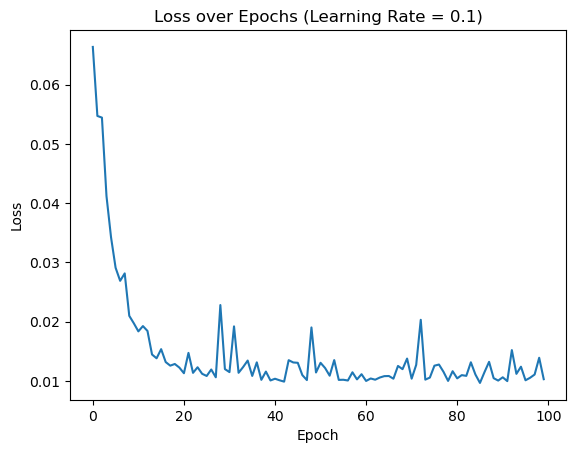

Final Amplitude of Predicted Signal (LR = 0.1): 1.9921684265136719


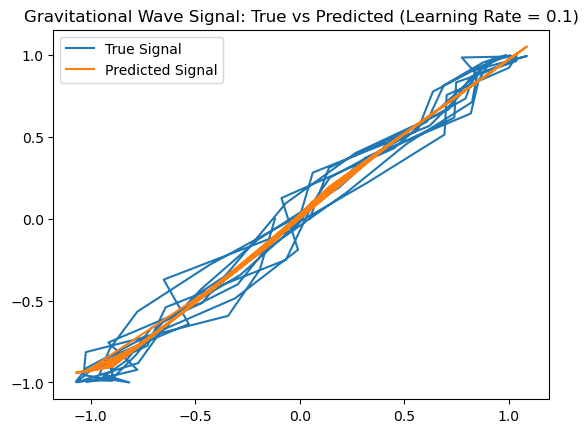

Step 1: Loss = 0.6643081903457642, Amplitude = 0.34409722685813904
Step 2: Loss = 0.3969859182834625, Amplitude = 0.22791394591331482
Step 3: Loss = 0.2831655442714691, Amplitude = 0.6514828205108643
Step 4: Loss = 0.26538383960723877, Amplitude = 0.621475100517273
Step 5: Loss = 0.22824479639530182, Amplitude = 1.5013220310211182
Step 6: Loss = 0.5141646862030029, Amplitude = 0.6284688711166382
Step 7: Loss = 0.6589995622634888, Amplitude = 2.0872530937194824
Step 8: Loss = 1.3812096118927002, Amplitude = 0.2243058681488037
Step 9: Loss = 0.49083706736564636, Amplitude = 0.035882677882909775
Step 10: Loss = 0.46419960260391235, Amplitude = 0.08310804516077042
info_lr_05_lr_0.5.csv saved successfully!
Epoch 1/100
4/4 [==============================] - 0s 561us/step - loss: 0.3642
Epoch 2/100
4/4 [==============================] - 0s 402us/step - loss: 0.0939
Epoch 3/100
4/4 [==============================] - 0s 377us/step - loss: 0.9978
Epoch 4/100
4/4 [==============================] 

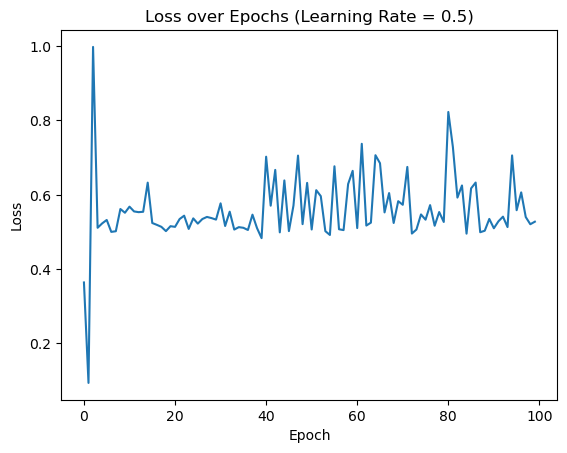

Final Amplitude of Predicted Signal (LR = 0.5): 0.0


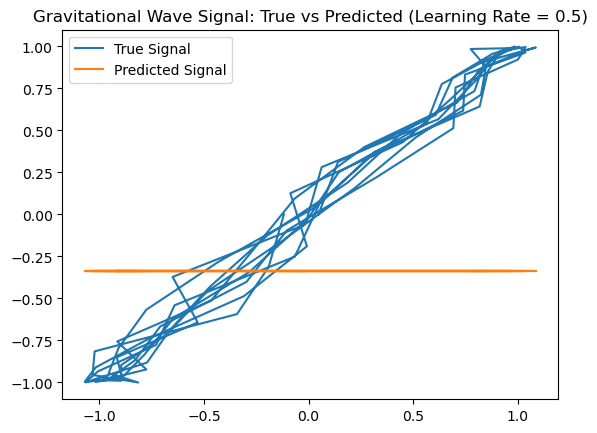

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd

# Function to generate noisy gravitational wave-like data
def generate_gw_data(n_samples, noise_level=0.1):
    time = np.linspace(0, 1, n_samples)
    signal = np.sin(2 * np.pi * time * 5)  # Simulated GW signal (sine wave)
    noise = noise_level * np.random.randn(n_samples)  # Adding Gaussian noise
    data = signal + noise
    return data, signal

# Prepare data
n_samples = 100
x_data, y_data = generate_gw_data(n_samples)
x_data = x_data.reshape(-1, 1)
y_data = y_data.reshape(-1, 1)

# Function to build and compile the model
def build_model(learning_rate):
    model = models.Sequential([
        layers.Dense(5, activation='relu', input_shape=(1,)),  # First hidden layer (5 neurons)
        layers.Dense(5, activation='relu'),                    # Second hidden layer
        layers.Dense(1)                                        # Output layer (1 neuron for regression)
    ])
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model, optimizer

# Function to extract and save model information, including amplitude
def extract_model_info(model, x_data, y_data, optimizer, n_steps=10):
    info = {"step": [], "weights": [], "gradients": [], "outputs": [], "amplitude": [], "loss": []}

    for step in range(n_steps):
        with tf.GradientTape() as tape:
            predictions = model(x_data)
            loss_value = tf.keras.losses.mean_squared_error(y_data, predictions)
            loss_value = tf.reduce_mean(loss_value)

        gradients = tape.gradient(loss_value, model.trainable_variables)
        weights = model.trainable_variables
        optimizer.apply_gradients(zip(gradients, weights))

        # Calculate amplitude: max(predictions) - min(predictions)
        amplitude = np.max(predictions.numpy()) - np.min(predictions.numpy())

        # Store all relevant information
        info["step"].append(step + 1)
        info["weights"].append([w.numpy().flatten() for w in weights])
        info["gradients"].append([g.numpy().flatten() for g in gradients])
        info["outputs"].append(predictions.numpy().flatten())
        info["amplitude"].append(amplitude)
        info["loss"].append(loss_value.numpy())

        print(f"Step {step + 1}: Loss = {loss_value.numpy()}, Amplitude = {amplitude}")

    return info

# Function to save the extracted information to CSV
def save_info_to_csv(info, filename):
    table = pd.DataFrame({
        'Step': info["step"],
        'Loss': info["loss"],
        'Amplitude': info["amplitude"],
        'Weights (Layer 1)': [str(w[0]) for w in info["weights"]],  
        'Gradients (Layer 1)': [str(g[0]) for g in info["gradients"]],  
        'Outputs': [str(o) for o in info["outputs"]]
    })
    table.to_csv(filename, index=False)
    print(f"{filename} saved successfully!")

# Function to train model and generate plots
def train_and_plot_model(learning_rate, x_data, y_data, epochs, filename_prefix):
    model, optimizer = build_model(learning_rate)
    
    # Extract information over 10 steps
    info = extract_model_info(model, x_data, y_data, optimizer)
    
    # Save to CSV
    csv_filename = f'{filename_prefix}_lr_{learning_rate}.csv'
    save_info_to_csv(info, csv_filename)
    
    # Train the model for more epochs
    history = model.fit(x_data, y_data, epochs=epochs, verbose=1)
    
    # Plot loss over epochs
    plt.plot(history.history['loss'])
    plt.title(f'Loss over Epochs (Learning Rate = {learning_rate})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    # Predict to compare true vs predicted signals
    y_pred = model.predict(x_data)

    # Calculate amplitude of the final predicted signal
    final_amplitude = np.max(y_pred) - np.min(y_pred)
    print(f"Final Amplitude of Predicted Signal (LR = {learning_rate}): {final_amplitude}")

    # Plot the noisy data, true signal, and predicted signal
    plt.plot(x_data, y_data, label='True Signal')
    plt.plot(x_data, y_pred, label='Predicted Signal')
    plt.legend()
    plt.title(f'Gravitational Wave Signal: True vs Predicted (Learning Rate = {learning_rate})')
    plt.show()

# Train and plot for learning rate = 0.1
train_and_plot_model(learning_rate=0.1, x_data=x_data, y_data=y_data, epochs=100, filename_prefix='info_lr_01')

# Train and plot for learning rate = 0.5
train_and_plot_model(learning_rate=0.5, x_data=x_data, y_data=y_data, epochs=100, filename_prefix='info_lr_05')

In [4]:
import pandas as pd

# Load CSV file
df_lr_01 = pd.read_csv('info_lr_01_lr_0.1.csv')
df_lr_01

,Step,Weights (Layer 1),Gradients (Layer 1),Unnamed: 3,Output,Loss
0,1,[ 0.8669659 -0.01021131 0.8163032 0.017106...,[-0.01474498 0.08346401 -0.14783329 -0.027161...,NaN,0.579949,0.304189
1,2,[ 0.8692773 -0.03989618 0.82959145 0.019328...,[-0.02311431 0.29684862 -0.13288252 -0.022219...,NaN,0.723741,0.256569
2,3,[ 0.8725587 -0.04872571 0.84388673 0.021539...,[-0.03281416 0.08829531 -0.14295293 -0.022107...,NaN,0.842752,0.208735
3,4,[ 0.8756423 -0.06438935 0.8548361 0.023047...,[-0.03083608 0.15663643 -0.10949396 -0.015080...,NaN,1.003722,0.170488
4,5,[ 0.8789087 -0.07180712 0.8651452 0.024386...,[-0.03266374 0.07417766 -0.10309114 -0.013389...,NaN,1.103416,0.145858
5,6,[ 0.8814277 -0.08448908 0.872332 0.025214...,[-0.02518997 0.12681958 -0.07186781 -0.008275...,NaN,1.230512,0.122735
6,7,[ 0.8838949 -0.09051623 0.87892157 0.025985...,[-0.02467204 0.06027157 -0.06589598 -0.007715...,NaN,1.306322,0.107312
7,8,[ 0.8854969 -0.104607 0.8828858 0.026382...,[-0.01602 0.14090772 -0.03964229 -0.003971...,NaN,1.404978,0.093893
8,9,[ 0.887363 -0.10981941 0.887373 0.026843...,[-0.01866129 0.05212412 -0.04487128 -0.004609...,NaN,1.447958,0.085161
9,10,[ 0.88820815 -0.11698326 0.8891579 0.026956...,[-0.00845115 0.07163852 -0.01784905 -0.001131...,NaN,1.531464,0.075505


In [3]:
# Convert to LaTeX format (for Learning Rate = 0.1)
latex_table_lr_01 = df_lr_01.to_latex(index=False)

# Save LaTeX table to a .tex file
with open('info_lr_01_lr_0.1.tex', 'w') as f:
    f.write(latex_table_lr_01)

print("LaTeX table for Learning Rate 0.1 saved successfully!")

# Load another CSV for Learning Rate = 0.5 and convert to LaTeX
df_lr_05 = pd.read_csv('info_lr_05_lr_0.5.csv')
latex_table_lr_05 = df_lr_05.to_latex(index=False)

with open('info_lr_05_lr_0.5.tex', 'w') as f:
    f.write(latex_table_lr_05)

print("LaTeX table for Learning Rate 0.5 saved successfully!")

LaTeX table for Learning Rate 0.1 saved successfully!
LaTeX table for Learning Rate 0.5 saved successfully!


/var/folders/45/p3yqhznd40vfxfpn3g_df45c0000gn/T/ipykernel_45450/2039691422.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table_lr_01 = df_lr_01.to_latex(index=False)
/var/folders/45/p3yqhznd40vfxfpn3g_df45c0000gn/T/ipykernel_45450/2039691422.py:17: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table_lr_05 = df_lr_05.to_latex(index=False)
